In [ ]:
!pip install timm
!pip install lightning
!pip install astropy
import torch
import torch.nn as nn
import timm
import numpy as np
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm


import sys
sys.path.append('/content/')

from dataloader_fits import SunImageDataset

from lightning.fabric import Fabric

import math
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import pandas as pd

import scipy.stats as stats

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 110.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 85.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 52.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 39.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 19.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 88.0 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitl

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import zipfile

zip_path = '/content/drive/MyDrive/Dataset/aia_synoptic_copy_1.zip'
extract_path = '/content/'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

In [ ]:
# Hyper-parameters
input_size = 224*224
hidden_size = 166
# hidden_size = 1024
num_epochs = 10
batch_size = 2
learning_rate = 0.001
dropout = 0.5
lstm_layers = 2

k_folds = 5

In [ ]:
import random
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)

set_seed(42)

In [ ]:
dataset = SunImageDataset(csv_file="/content/dataset_collab_full_5days.csv", offset=0)

total_size = len(dataset)
fold_size = total_size // k_folds
indices = list(range(total_size))

k_fold_1_indices = indices[:fold_size]
k_fold_2_indices = indices[fold_size:2*fold_size]
k_fold_3_indices = indices[2*fold_size:3*fold_size]
k_fold_4_indices = indices[3*fold_size:4*fold_size]
k_fold_5_indices = indices[4*fold_size:]

print(len(k_fold_1_indices))
print(len(k_fold_2_indices))
print(len(k_fold_3_indices))
print(len(k_fold_4_indices))
print(len(k_fold_5_indices))

dataloaders = [k_fold_1_indices, k_fold_2_indices, k_fold_3_indices, k_fold_4_indices, k_fold_5_indices]

# Get date list
kp_dates = pd.read_csv("/content/matched_kp_dates_collab_full_5days.csv")
kp_dates_list = kp_dates["date"].tolist()

1097
1097
1097
1097
1099


In [ ]:
# Get active indices
dataset_csv_file = pd.read_csv("/content/dataset_collab_full_5days.csv")
active_indices = []

for i in dataset_csv_file.index:
    if dataset_csv_file['Kp'][i] >= 3.667:
        active_indices.append(i)

active_dataloaders = []
for dataloader in dataloaders:
    active_dataloaders.append(list(set(dataloader) & set(active_indices)))

for dataloader in active_dataloaders:
    print(len(dataloader))

241
222
393
438
282


In [ ]:

class GmiSwinTransformer(nn.Module):
    def __init__(self, hidden_size: int):
        super(GmiSwinTransformer, self).__init__()

        # Batch normalization for 3 channels
        self.bn = nn.BatchNorm2d(3)

        # Initialize Swin Transformer
        self.pretrained_model = timm.create_model(
            'swin_base_patch4_window7_224',
            pretrained=True,
            num_classes=hidden_size
        )


        self.lstm = nn.LSTM(hidden_size, hidden_size * 2, lstm_layers, batch_first=True)

        # Fully connected layers
        self.fc = nn.Sequential(
            nn.LeakyReLU(),
            nn.Dropout(p=dropout),
            nn.Linear(hidden_size*2, hidden_size),
            nn.Dropout(p=dropout),  # Added dropout probability
            nn.LeakyReLU(),
            nn.Linear(hidden_size, 1),
            # nn.LeakyReLU()

        )

    def forward(self, images) -> torch.Tensor:
        """
        Batch should be in format:
        {
            'images': torch.FloatTensor((10, 1, 224, 224))
        }
        """

        batch_size = images.shape[0]

        images = images.reshape(-1, 1, 224, 224)
        images = torch.cat([images, images, images], dim=1)
        normalized_images = self.bn(images)
        features = self.pretrained_model(normalized_images)
        image_features = features.view(batch_size, 10, -1)

        # hidden_states = torch.zeros(lstm_layers, image_features.size(0), hidden_size * 2)
        # cell_states = torch.zeros(lstm_layers, image_features.size(0), hidden_size * 2)
        # image_features, _ = self.lstm(image_features, (hidden_states, cell_states))
        image_features, _ = self.lstm(image_features)

        image_features = image_features[:, -1, :]
        output = self.fc(image_features)
        return output

# Initialize model
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model = GmiSwinTransformer(hidden_size=hidden_size).to(device)
model = GmiSwinTransformer(hidden_size=hidden_size)

# print(torchsummary.summary(model, (10, 1, 224, 224)))

# Loss and optimizer
criterion = nn.MSELoss()

model.safetensors:   0%|          | 0.00/353M [00:00<?, ?B/s]

In [ ]:
torch.cuda.empty_cache()

In [ ]:
def calculate_rates(all_outputs, all_labels):
    storm_labels = []
    for output in all_labels:
        if output < 3.667:
            storm_labels.append(0)
        else:
            storm_labels.append(1)
    storm_outputs = []
    for output in all_outputs:
        if output < 3.667:
            storm_outputs.append(0)
        else:
            storm_outputs.append(1)

    # Calculate true positive, true negative, false positive, false negative
    tp = 0
    tn = 0
    fp = 0
    fn = 0

    for i in range(len(storm_labels)):
        if storm_labels[i] == 1 and storm_outputs[i] == 1:
            tp += 1
        elif storm_labels[i] == 0 and storm_outputs[i] == 0:
            tn += 1
        elif storm_labels[i] == 0 and storm_outputs[i] == 1:
            fp += 1
        elif storm_labels[i] == 1 and storm_outputs[i] == 0:
            fn += 1

    return tp, tn, fp, fn


def true_skill_score(tp, tn, fp, fn):

    # Calculate true skill score
    tss = (tp / (tp + fp)) - (fp / (fp + tn)) if ((tp > 0 and tn > 0) or fp > 0) else 0
    return tss

def calculate_metrics(tp, tn, fp, fn):
    # Calculate accuracy
    accuracy = (tp + tn) / (tp + tn + fp + fn) if (tp + tn + fp + fn) > 0 else 0

    # Calculate precision
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0

    # Calculate recall
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0

    # Calculate F1 score
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

    return accuracy, precision, recall, f1





In [ ]:
def train_model(fabric):
  print(fabric.device)
  total_avg_test_loss = 0
  total_rmse = 0
  total_mse = 0
  total_mae = 0
  total_r2 = 0
  total_r = 0
  total_tts = 0
  total_accuracy = 0
  total_precision = 0
  total_recall = 0
  total_f1 = 0

  active_total_avg_test_loss = 0
  active_total_rmse = 0
  active_total_mse = 0
  active_total_mae = 0
  active_total_r2 = 0
  active_total_r = 0


  for i in range(k_folds):
      print(f'FOLD {i + 1}')
      print('--------------------------------')
      test_indices = dataloaders[i]
      active_test_indices = active_dataloaders[i]
      train_indices = []
      for j in range(k_folds):
          if j != i:
              train_indices += dataloaders[j]

      trainloader = torch.utils.data.DataLoader(dataset=torch.utils.data.Subset(dataset, train_indices), batch_size=batch_size, shuffle=True, num_workers=20, prefetch_factor=6, pin_memory=True, worker_init_fn=lambda _: np.random.seed(42))
      testloader = torch.utils.data.DataLoader(dataset=torch.utils.data.Subset(dataset, test_indices), batch_size=batch_size, shuffle=False, num_workers=20, prefetch_factor=6, pin_memory=True)
      active_testloader = torch.utils.data.DataLoader(dataset=torch.utils.data.Subset(dataset, active_test_indices), batch_size=batch_size, shuffle=False, num_workers=20, prefetch_factor=6, pin_memory=True)
      trainloader = fabric.setup_dataloaders(trainloader)
      testloader = fabric.setup_dataloaders(testloader)
      active_testloader = fabric.setup_dataloaders(active_testloader)


      # Reinitialize model
      model = GmiSwinTransformer(hidden_size=hidden_size)
      optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
      model, optimizer = fabric.setup(model, optimizer)
      model.train()

      # Training the model
      n_total_steps = len(trainloader)
      avg_train_loss_over_epochs = []
      avg_val_loss_over_epochs = []

      for epoch in range(num_epochs):
          train_losses = []
          val_losses = []

          # Training loop
          model.train()
          for i, (images, labels) in tqdm(enumerate(trainloader), desc=f"Training Progress: Epoch: {epoch + 1}", total=len(trainloader)):
              # Move images and labels to device
              images = images.float()
              labels = labels.float()

              # Forward pass with autograd
              outputs = model(images).squeeze(1)
              loss = criterion(outputs, labels)
              # tqdm.write(f"Epoch: {epoch+1}, Index: {i}, Loss: {loss.item():.4f}")

              # Backward pass and optimization
              optimizer.zero_grad()
              fabric.backward(loss)
              optimizer.step()
              # Store the loss
              train_losses.append(loss.item())

          # Store the average training loss for this epoch
          avg_train_loss_over_epochs.append(sum(train_losses) / len(train_losses))
          print("Average Training Loss: ", sum(train_losses) / len(train_losses))

          # Validation loop
          model.eval()
          with torch.no_grad():
              for images, labels in tqdm(testloader, desc=f"Validation Progress: Epoch: {epoch + 1}", total=len(testloader)):
                  images = images.float()
                  # images = images.permute(1, 0, 2, 3, 4)
                  labels = labels.float()
                  outputs = model(images).squeeze(1)
                  loss = criterion(outputs, labels)
                  # print("Validation Loss: ", loss.item())
                  val_losses.append(loss.item())

          # Store the average validation loss for this epoch
          avg_val_loss_over_epochs.append(sum(val_losses) / len(val_losses))
          print("Average Validation Loss: ", sum(val_losses) / len(val_losses))

      # Plot loss over epochs
      plt.figure()
      plt.plot(range(1, num_epochs + 1), avg_train_loss_over_epochs, label='Average Training Loss', marker='o')
      plt.plot(range(1, num_epochs + 1), avg_val_loss_over_epochs, label='Average Validation Loss', marker='o')
      plt.xticks(range(1, num_epochs + 1))  # Ensure x-axis includes all epoch numbers
      plt.xlabel('Epoch')
      plt.ylabel('Average Loss')
      plt.legend()
      plt.title('Training and Validation Loss Over Epochs')
      plt.show()

      test_losses = []
      all_labels = []
      all_outputs = []

      model.eval()

      print('--------------------------------')
      print('Test for Full set')
      print('--------------------------------')

  # Test for Full set
      with torch.no_grad():
          for images, labels in tqdm(testloader, desc="Testing Progress"):
              images = images.float()
              # images = images.permute(1, 0, 2, 3, 4)
              labels = labels.float()
              # print("Label: ", labels)
              outputs = model(images).squeeze(1)
              # print("Output: ", outputs)
              loss = criterion(outputs, labels)
              test_losses.append(loss.item())
              all_labels.extend(labels.cpu().numpy())
              all_outputs.extend(outputs.cpu().numpy())

      avg_test_loss = sum(test_losses) / len(test_losses)
      rmse = math.sqrt(avg_test_loss)
      mse = mean_squared_error(all_labels, all_outputs)
      mae = mean_absolute_error(all_labels, all_outputs)
      r2 = r2_score(all_labels, all_outputs)
      r, _ = stats.pearsonr(all_labels, all_outputs)
      tp, tn, fp, fn = calculate_rates(all_outputs, all_labels)
      accuracy, precision, recall, f1 = calculate_metrics(tp, tn, fp, fn)
      tts = true_skill_score(tp, tn, fp, fn)



      # Accumulate metrics for averaging across folds
      total_avg_test_loss += avg_test_loss
      total_rmse += rmse
      total_mse += mse
      total_mae += mae
      total_r2 += r2
      total_r += r
      total_tts += tts
      total_accuracy += accuracy
      total_precision += precision
      total_recall += recall
      total_f1 += f1


      print(f'Average test loss: {avg_test_loss:.4f}')
      print(f'RMSE: {rmse:.4f}')
      print(f'MSE: {mse:.4f}')
      print(f'MAE: {mae:.4f}')
      print(f'R²: {r2:.4f}')
      print(f'R: {r:.4f}')
      print(f'True Skill Score: {tts:.4f}')
      print(f'Accuracy: {accuracy:.4f}')
      print(f'Precision: {precision:.4f}')
      print(f'Recall: {recall:.4f}')
      print(f'F1 Score: {f1:.4f}')

      test_dates = list(kp_dates_list[i] for i in test_indices)
      # Convert to pandas Series for easy rolling average calculation
      labels_series = pd.Series(all_labels)
      outputs_series = pd.Series(all_outputs)

      # Calculate rolling averages with window size of 5
      window_size = 2
      labels_rolling = labels_series.rolling(window=window_size, center=True).mean()
      outputs_rolling = outputs_series.rolling(window=window_size, center=True).mean()

      # Create a better-looking plot
      plt.figure(figsize=(50, 6), facecolor='#f8f9fa')
      plt.plot([0, len(test_dates)], [3.667, 3.667], 'r--', alpha=0.6, label='Kp = 4-')
      # Plot original data with thin lines
      plt.plot(all_labels, '-', color='#1f77b4', linewidth=1, alpha=0.6, label='Actual Labels')
      plt.plot(all_outputs, '--', color='#ff7f0e', linewidth=1, alpha=0.6, label='Predicted Labels')

      # Plot smoothed data with thicker lines
      plt.plot(labels_rolling, '-', color='#2c5282', linewidth=2.5, label='Actual Labels (Smoothed)')
      plt.plot(outputs_rolling, '--', color='#c05621', linewidth=2.5, label='Predicted Labels (Smoothed)')

      # Format x-axis with dates
      test_dates_sliced = test_dates[0:len(all_labels):20]
      plt.xticks(range(0, len(test_dates), 20), test_dates_sliced, rotation=30, ha='right')

      # Better grid styling
      plt.grid(True, linestyle='--', alpha=0.7)

      # Improve labels and title
      plt.xlabel('Date', fontsize=12)
      plt.ylabel('KP Index', fontsize=12)
      plt.title('Comparison of Actual vs Predicted KP Index Values', fontsize=14)

      # Better legend
      plt.legend(loc='best', frameon=True, fontsize=12)

      # Adjust layout for better spacing
      plt.tight_layout()

      plt.show()
      print(all_outputs)

      print('--------------------------------')
      print('Test for Active Periods')
      print('--------------------------------')

      test_losses = []
      all_labels = []
      all_outputs = []

  # Test for active periods
      with torch.no_grad():
          for images, labels in tqdm(active_testloader, desc="Testing Progress"):
              images = images.float()
              labels = labels.float()
              outputs = model(images).squeeze(1)
              loss = criterion(outputs, labels)
              test_losses.append(loss.item())
              all_labels.extend(labels.cpu().numpy())
              all_outputs.extend(outputs.cpu().numpy())

      avg_test_loss = sum(test_losses) / len(test_losses)
      rmse = math.sqrt(avg_test_loss)
      mse = mean_squared_error(all_labels, all_outputs)
      mae = mean_absolute_error(all_labels, all_outputs)
      r2 = r2_score(all_labels, all_outputs)
      r, _ = stats.pearsonr(all_labels, all_outputs)



      # Accumulate metrics for averaging across folds
      active_total_avg_test_loss += avg_test_loss
      active_total_rmse += rmse
      active_total_mse += mse
      active_total_mae += mae
      active_total_r2 += r2
      active_total_r += r




      print(f'Average test loss: {avg_test_loss:.4f}')
      print(f'RMSE: {rmse:.4f}')
      print(f'MSE: {mse:.4f}')
      print(f'MAE: {mae:.4f}')
      print(f'R²: {r2:.4f}')
      print(f'R: {r:.4f}')
      # Convert to pandas Series for easy rolling average calculation
      labels_series = pd.Series(all_labels)
      outputs_series = pd.Series(all_outputs)

      # Calculate rolling averages with a window size of 5
      window_size = 2
      labels_rolling = labels_series.rolling(window=window_size, center=True).mean()
      outputs_rolling = outputs_series.rolling(window=window_size, center=True).mean()

      # Create a better-looking plot
      plt.figure(figsize=(50, 6), facecolor='#f8f9fa')

      plt.plot([0, len(all_labels)], [3.667, 3.667], 'r--', alpha=0.6, label='Kp = 4-')

      # Plot original data with thin lines
      plt.plot(all_labels, '-', color='#1f77b4', linewidth=1, alpha=0.6, label='Actual Labels')
      plt.plot(all_outputs, '--', color='#ff7f0e', linewidth=1, alpha=0.6, label='Predicted Labels')

      # Plot smoothed data with thicker lines
      plt.plot(labels_rolling, '-', color='#2c5282', linewidth=2.5, label='Actual Labels (Smoothed)')
      plt.plot(outputs_rolling, '--', color='#c05621', linewidth=2.5, label='Predicted Labels (Smoothed)')

      # Better grid styling
      plt.grid(True, linestyle='--', alpha=0.7)

      # Improve labels and title
      plt.xlabel('Sample Index', fontsize=12)
      plt.ylabel('KP Index', fontsize=12)
      plt.title('Comparison of Actual vs Predicted KP Index Values', fontsize=14)

      # Better legend
      plt.legend(loc='best', frameon=True, fontsize=12)

      # Adjust layout for better spacing
      plt.tight_layout()

      plt.show()
      print(all_outputs)


  print('--------------------------------')
  print('Metrics for Full Set')
  print('--------------------------------')

  # Average metrics across all folds
  total_avg_test_loss /= k_folds
  total_rmse /= k_folds
  total_mse /= k_folds
  total_mae /= k_folds
  total_r2 /= k_folds
  total_r /= k_folds
  total_tts /= k_folds
  total_accuracy /= k_folds
  total_precision /= k_folds
  total_recall /= k_folds
  total_f1 /= k_folds

  print(f'Average test loss across all folds: {total_avg_test_loss:.4f}')
  print(f'Average RMSE across all folds: {total_rmse:.4f}')
  print(f'Average MSE across all folds: {total_mse:.4f}')
  print(f'Average MAE across all folds: {total_mae:.4f}')
  print(f'Average R² across all folds: {total_r2:.4f}')
  print(f'Average R across all folds: {total_r:.4f}')
  print(f'Average True Skill Score across all folds: {total_tts:.4f}')
  print(f'Average Accuracy across all folds: {total_accuracy:.4f}')
  print(f'Average Precision across all folds: {total_precision:.4f}')
  print(f'Average Recall across all folds: {total_recall:.4f}')
  print(f'Average F1 Score across all folds: {total_f1:.4f}')

  print('--------------------------------')
  print('Metrics for Active Periods')
  print('--------------------------------')
  # Average metrics across all folds
  active_total_avg_test_loss /= k_folds
  active_total_rmse /= k_folds
  active_total_mse /= k_folds
  active_total_mae /= k_folds
  active_total_r2 /= k_folds
  active_total_r /= k_folds

  print(f'Average active test loss across all folds: {active_total_avg_test_loss:.4f}')
  print(f'Average active RMSE across all folds: {active_total_rmse:.4f}')
  print(f'Average active MSE across all folds: {active_total_mse:.4f}')
  print(f'Average active MAE across all folds: {active_total_mae:.4f}')
  print(f'Average active R² across all folds: {active_total_r2:.4f}')
  print(f'Average active R across all folds: {active_total_r:.4f}')




INFO: Using bfloat16 Automatic Mixed Precision (AMP)
INFO:lightning.pytorch.utilities.rank_zero:Using bfloat16 Automatic Mixed Precision (AMP)


cuda:0
FOLD 1
--------------------------------


Training Progress: Epoch: 1:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  2.2878922419239616


Validation Progress: Epoch: 1:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  1.6214042347542033


Training Progress: Epoch: 2:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  1.7077805932272987


Validation Progress: Epoch: 2:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  1.5152515091530203


Training Progress: Epoch: 3:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  1.3746018356205005


Validation Progress: Epoch: 3:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  2.1724138817506486


Training Progress: Epoch: 4:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  1.0154396955007137


Validation Progress: Epoch: 4:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  1.6773474455723294


Training Progress: Epoch: 5:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  0.7951277577588738


Validation Progress: Epoch: 5:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  1.6845992932423528


Training Progress: Epoch: 6:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  0.6521049875102684


Validation Progress: Epoch: 6:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  1.8837373700021165


Training Progress: Epoch: 7:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  0.526148264485057


Validation Progress: Epoch: 7:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  1.7403927617062787


Training Progress: Epoch: 8:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  0.4378690523195403


Validation Progress: Epoch: 8:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  2.007895560310229


Training Progress: Epoch: 9:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  0.3816198921149436


Validation Progress: Epoch: 9:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  2.1909298312620145


Training Progress: Epoch: 10:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  0.3381905327092168


Validation Progress: Epoch: 10:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  1.7833568860129123


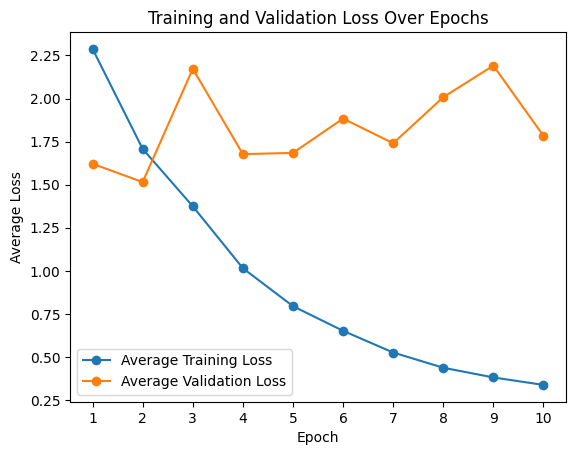

--------------------------------
Test for Full set
--------------------------------


Testing Progress:   0%|          | 0/549 [00:00<?, ?it/s]

Average test loss: 1.7834
RMSE: 1.3354
MSE: 1.7850
MAE: 1.0483
R²: -0.1706
R: 0.1734
True Skill Score: 0.1842
Accuracy: 0.7375
Precision: 0.2718
Recall: 0.1162
F1 Score: 0.1628


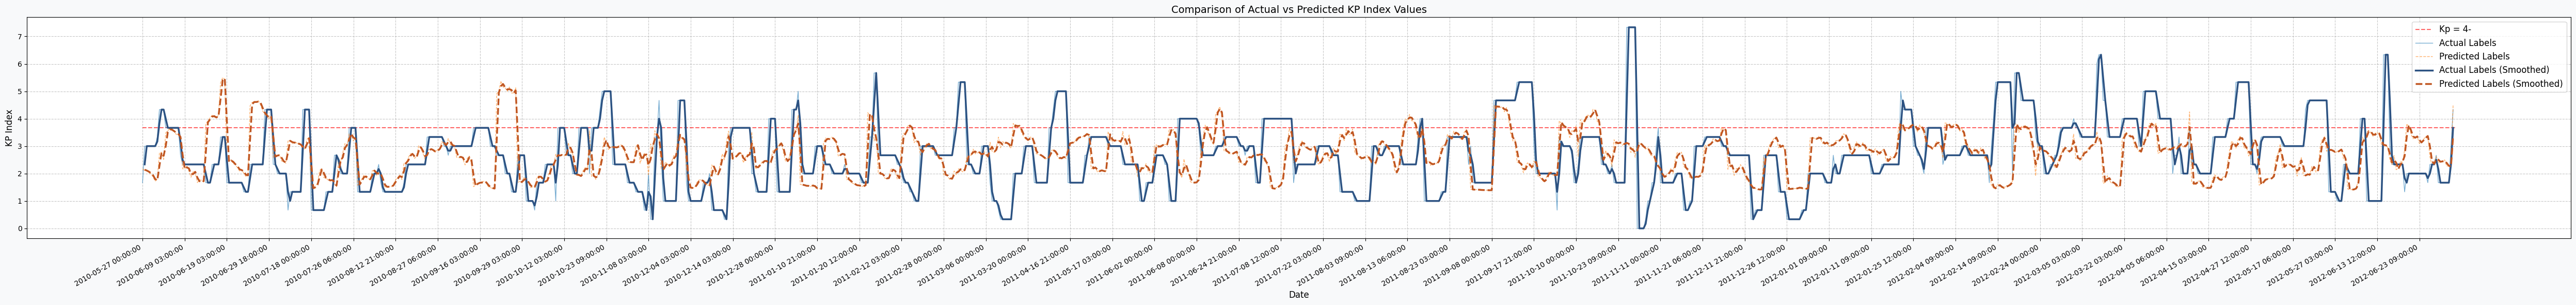

[np.float32(2.171875), np.float32(2.109375), np.float32(2.109375), np.float32(2.03125), np.float32(2.0), np.float32(1.875), np.float32(1.71875), np.float32(1.796875), np.float32(2.75), np.float32(2.78125), np.float32(2.515625), np.float32(3.484375), np.float32(3.5625), np.float32(3.65625), np.float32(3.546875), np.float32(3.546875), np.float32(3.421875), np.float32(3.453125), np.float32(3.21875), np.float32(2.171875), np.float32(2.171875), np.float32(2.28125), np.float32(2.09375), np.float32(1.8671875), np.float32(2.09375), np.float32(2.03125), np.float32(1.671875), np.float32(1.765625), np.float32(1.7578125), np.float32(1.6875), np.float32(3.8125), np.float32(3.921875), np.float32(4.03125), np.float32(4.125), np.float32(4.0625), np.float32(4.03125), np.float32(4.125), np.float32(5.3125), np.float32(5.5), np.float32(5.4375), np.float32(2.390625), np.float32(2.453125), np.float32(2.5), np.float32(2.359375), np.float32(2.328125), np.float32(2.21875), np.float32(2.09375), np.float32(2.156

Testing Progress:   0%|          | 0/121 [00:00<?, ?it/s]

Average test loss: 3.6320
RMSE: 1.9058
MSE: 3.6333
MAE: 1.6180
R²: -4.8741
R: 0.1177


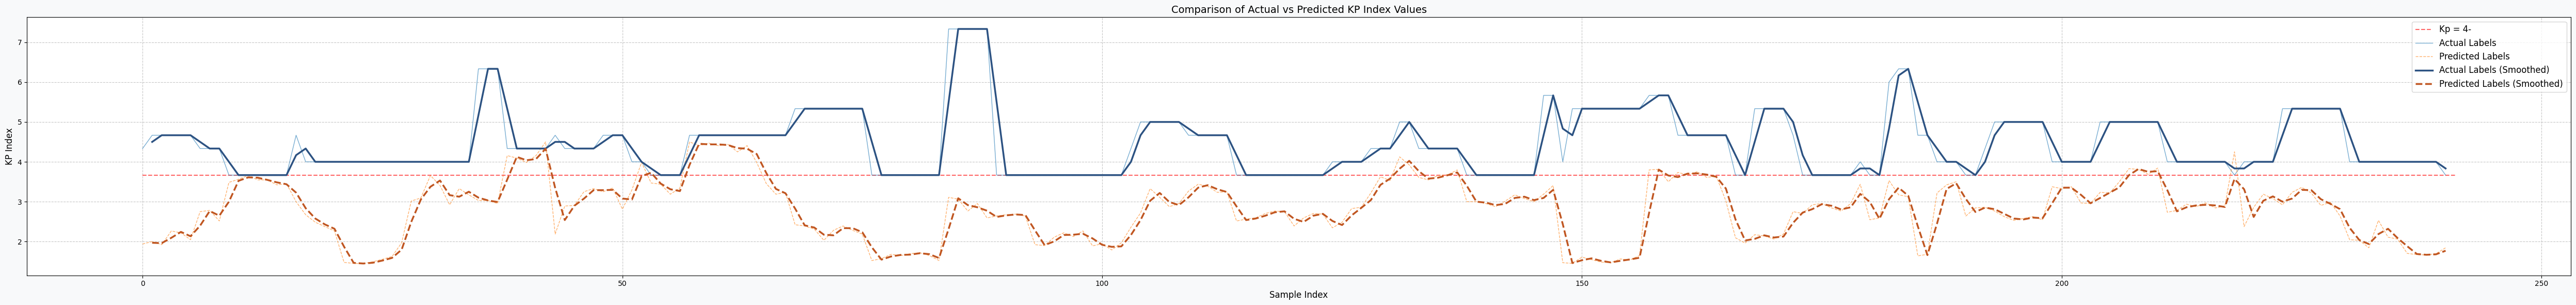

[np.float32(1.9375), np.float32(2.0), np.float32(1.921875), np.float32(2.265625), np.float32(2.21875), np.float32(2.046875), np.float32(2.75), np.float32(2.78125), np.float32(2.515625), np.float32(3.484375), np.float32(3.5625), np.float32(3.65625), np.float32(3.546875), np.float32(3.546875), np.float32(3.421875), np.float32(3.453125), np.float32(3.0), np.float32(2.671875), np.float32(2.484375), np.float32(2.375), np.float32(2.265625), np.float32(1.4765625), np.float32(1.453125), np.float32(1.4453125), np.float32(1.4921875), np.float32(1.5546875), np.float32(1.625), np.float32(1.96875), np.float32(3.015625), np.float32(3.09375), np.float32(3.65625), np.float32(3.40625), np.float32(2.921875), np.float32(3.328125), np.float32(3.171875), np.float32(3.03125), np.float32(3.03125), np.float32(2.953125), np.float32(4.15625), np.float32(4.09375), np.float32(3.984375), np.float32(4.15625), np.float32(4.5), np.float32(2.1875), np.float32(2.890625), np.float32(2.90625), np.float32(3.25), np.float3

Training Progress: Epoch: 1:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  2.186829251404199


Validation Progress: Epoch: 1:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  1.9375784389406632


Training Progress: Epoch: 2:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  1.511535079490843


Validation Progress: Epoch: 2:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  1.6839728691873441


Training Progress: Epoch: 3:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  1.179336829362612


Validation Progress: Epoch: 3:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  1.749477166294656


Training Progress: Epoch: 4:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  0.8987209567575819


Validation Progress: Epoch: 4:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  1.7286381825937454


Training Progress: Epoch: 5:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  0.6913943058409774


Validation Progress: Epoch: 5:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  1.8396901641482528


Training Progress: Epoch: 6:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  0.5687441863473754


Validation Progress: Epoch: 6:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  1.7718830944323287


Training Progress: Epoch: 7:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  0.46689178672074744


Validation Progress: Epoch: 7:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  2.0323749675155907


Training Progress: Epoch: 8:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  0.42007417139095016


Validation Progress: Epoch: 8:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  1.854338235318617


Training Progress: Epoch: 9:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  0.3703377724120262


Validation Progress: Epoch: 9:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  1.8632196530676193


Training Progress: Epoch: 10:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  0.31522143308888984


Validation Progress: Epoch: 10:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  1.966482476579816


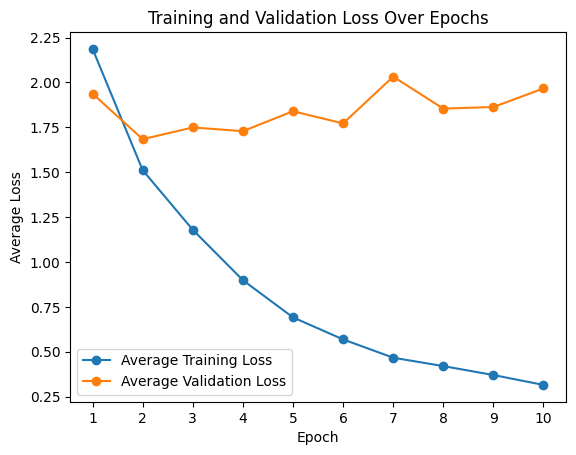

--------------------------------
Test for Full set
--------------------------------


Testing Progress:   0%|          | 0/549 [00:00<?, ?it/s]

Average test loss: 1.9665
RMSE: 1.4023
MSE: 1.9678
MAE: 1.1175
R²: -0.1411
R: 0.1227
True Skill Score: 0.3163
Accuracy: 0.7767
Precision: 0.3883
Recall: 0.1802
F1 Score: 0.2462


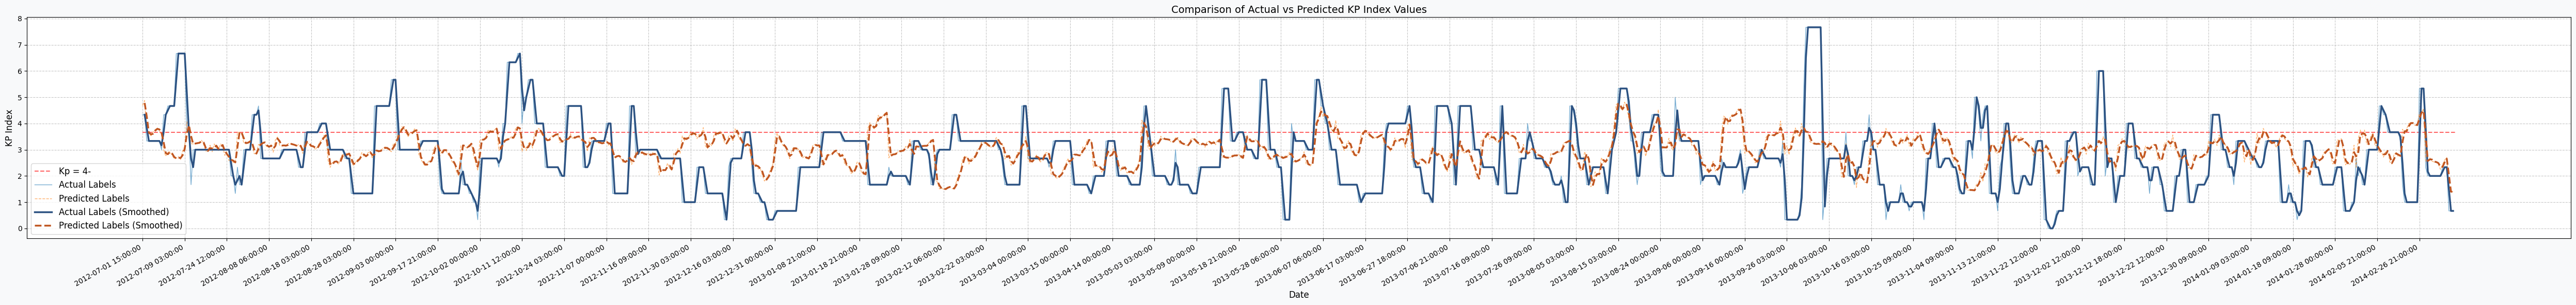

[np.float32(4.6875), np.float32(4.875), np.float32(3.65625), np.float32(3.640625), np.float32(3.53125), np.float32(3.6875), np.float32(3.765625), np.float32(3.828125), np.float32(3.71875), np.float32(3.578125), np.float32(3.0), np.float32(2.75), np.float32(2.90625), np.float32(2.921875), np.float32(2.796875), np.float32(2.65625), np.float32(2.671875), np.float32(2.734375), np.float32(2.625), np.float32(2.953125), np.float32(3.109375), np.float32(4.0625), np.float32(3.8125), np.float32(3.234375), np.float32(3.21875), np.float32(3.25), np.float32(3.25), np.float32(3.28125), np.float32(3.359375), np.float32(3.1875), np.float32(2.953125), np.float32(2.953125), np.float32(3.171875), np.float32(2.921875), np.float32(3.21875), np.float32(3.09375), np.float32(2.96875), np.float32(3.21875), np.float32(3.140625), np.float32(2.78125), np.float32(2.890625), np.float32(2.578125), np.float32(2.65625), np.float32(2.515625), np.float32(2.515625), np.float32(3.671875), np.float32(3.65625), np.float32(3

Testing Progress:   0%|          | 0/111 [00:00<?, ?it/s]

Average test loss: 3.1747
RMSE: 1.7818
MSE: 3.1747
MAE: 1.4604
R²: -2.4166
R: 0.1325


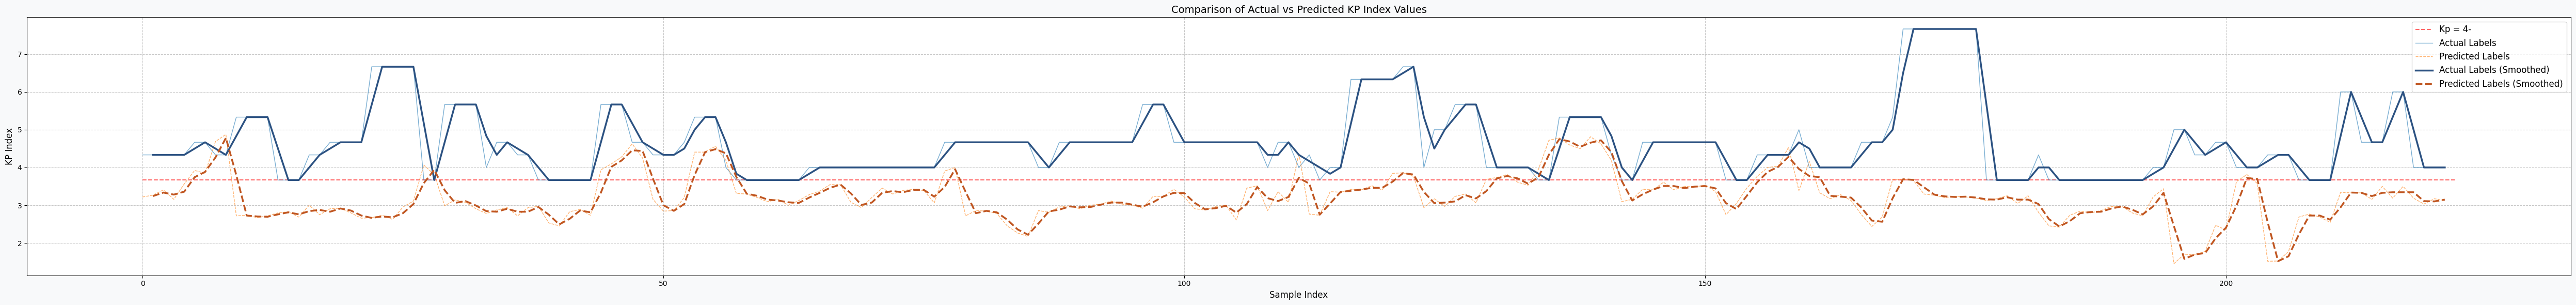

[np.float32(3.21875), np.float32(3.265625), np.float32(3.40625), np.float32(3.15625), np.float32(3.5625), np.float32(3.921875), np.float32(3.84375), np.float32(4.6875), np.float32(4.875), np.float32(2.71875), np.float32(2.734375), np.float32(2.671875), np.float32(2.71875), np.float32(2.796875), np.float32(2.828125), np.float32(2.6875), np.float32(3.0), np.float32(2.75), np.float32(2.90625), np.float32(2.921875), np.float32(2.796875), np.float32(2.65625), np.float32(2.671875), np.float32(2.734375), np.float32(2.625), np.float32(2.953125), np.float32(3.109375), np.float32(4.0625), np.float32(3.8125), np.float32(2.984375), np.float32(3.140625), np.float32(3.078125), np.float32(2.90625), np.float32(2.78125), np.float32(2.875), np.float32(2.9375), np.float32(2.71875), np.float32(2.9375), np.float32(2.96875), np.float32(2.53125), np.float32(2.453125), np.float32(2.828125), np.float32(2.890625), np.float32(2.734375), np.float32(3.9375), np.float32(4.09375), np.float32(4.28125), np.float32(4.6

Training Progress: Epoch: 1:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  2.1125311028921674


Validation Progress: Epoch: 1:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  1.6996525056619463


Training Progress: Epoch: 2:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  1.64017857953032


Validation Progress: Epoch: 2:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  1.9259836198344453


Training Progress: Epoch: 3:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  1.3615113084451647


Validation Progress: Epoch: 3:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  1.891395341208627


Training Progress: Epoch: 4:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  1.0519317750131674


Validation Progress: Epoch: 4:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  1.799977617923133


Training Progress: Epoch: 5:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  0.7888190406801577


Validation Progress: Epoch: 5:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  2.2397362355665322


Training Progress: Epoch: 6:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  0.6406284999878147


Validation Progress: Epoch: 6:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  1.8503727981835971


Training Progress: Epoch: 7:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  0.5282835953405783


Validation Progress: Epoch: 7:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  1.8241882937594964


Training Progress: Epoch: 8:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  0.44106470870905806


Validation Progress: Epoch: 8:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  1.7605069959842607


Training Progress: Epoch: 9:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  0.3589602951930172


Validation Progress: Epoch: 9:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  1.9024518080101729


Training Progress: Epoch: 10:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  0.3101796866690573


Validation Progress: Epoch: 10:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  1.9181490334922207


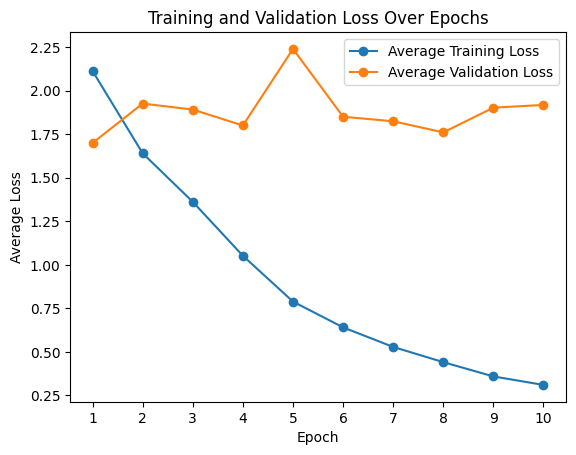

--------------------------------
Test for Full set
--------------------------------


Testing Progress:   0%|          | 0/549 [00:00<?, ?it/s]

Average test loss: 1.9181
RMSE: 1.3850
MSE: 1.9199
MAE: 1.1346
R²: -0.1299
R: 0.3473
True Skill Score: 0.3002
Accuracy: 0.6253
Precision: 0.4550
Recall: 0.2316
F1 Score: 0.3069


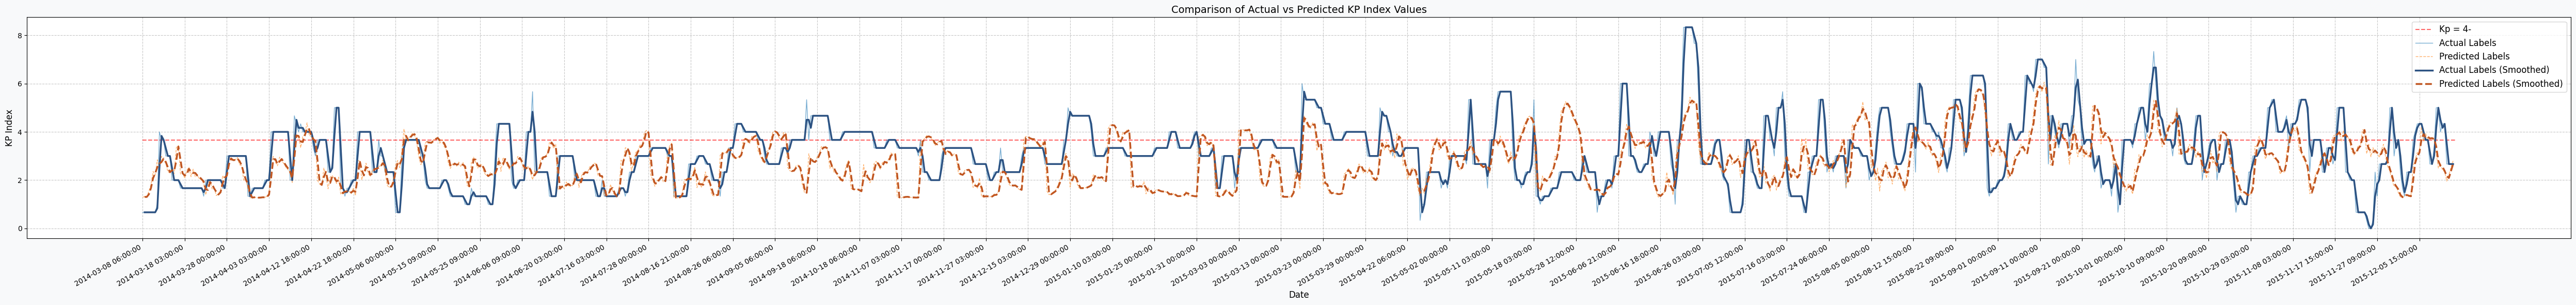

[np.float32(1.2890625), np.float32(1.3203125), np.float32(1.2890625), np.float32(1.5390625), np.float32(1.8125), np.float32(2.359375), np.float32(2.21875), np.float32(2.84375), np.float32(2.515625), np.float32(2.984375), np.float32(2.796875), np.float32(2.71875), np.float32(2.34375), np.float32(2.3125), np.float32(2.5), np.float32(2.265625), np.float32(3.34375), np.float32(3.4375), np.float32(2.25), np.float32(2.3125), np.float32(2.078125), np.float32(2.40625), np.float32(2.53125), np.float32(2.140625), np.float32(2.453125), np.float32(2.140625), np.float32(2.234375), np.float32(2.03125), np.float32(2.046875), np.float32(1.8359375), np.float32(1.390625), np.float32(1.796875), np.float32(2.03125), np.float32(1.6328125), np.float32(1.6640625), np.float32(1.359375), np.float32(1.4453125), np.float32(1.546875), np.float32(2.1875), np.float32(2.03125), np.float32(2.34375), np.float32(2.96875), np.float32(2.828125), np.float32(2.828125), np.float32(2.84375), np.float32(2.9375), np.float32(2.

Testing Progress:   0%|          | 0/197 [00:00<?, ?it/s]

Average test loss: 3.0011
RMSE: 1.7324
MSE: 2.9989
MAE: 1.5034
R²: -2.4297
R: 0.5728


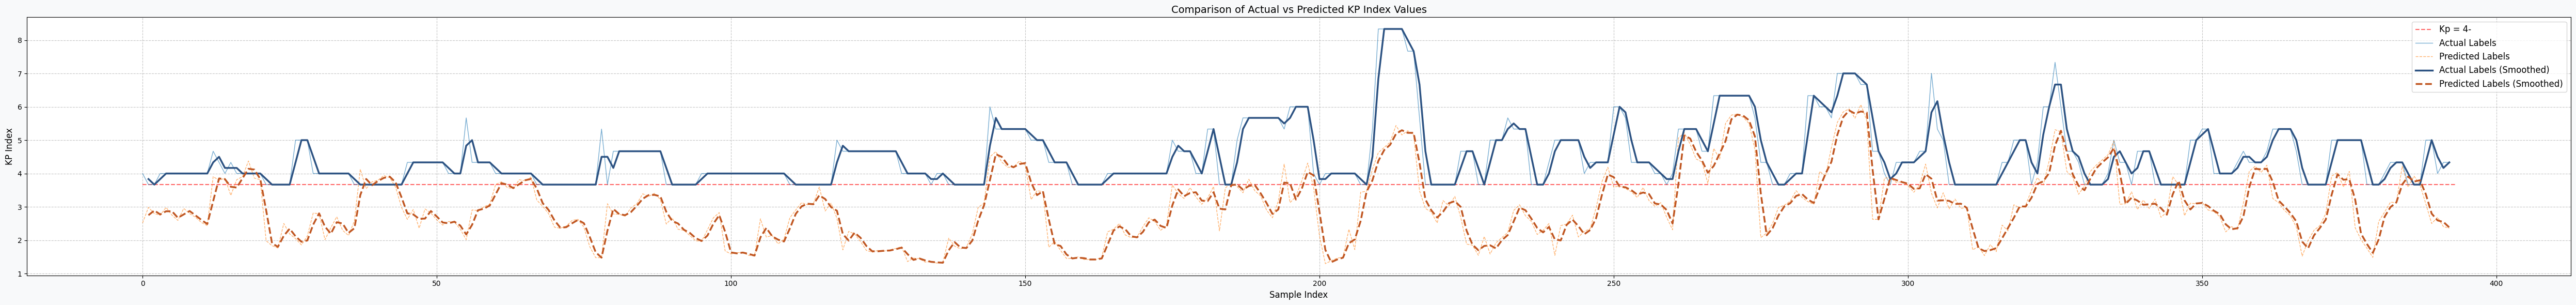

[np.float32(2.515625), np.float32(2.984375), np.float32(2.796875), np.float32(2.75), np.float32(2.984375), np.float32(2.75), np.float32(2.59375), np.float32(2.953125), np.float32(2.796875), np.float32(2.6875), np.float32(2.53125), np.float32(2.4375), np.float32(3.90625), np.float32(3.796875), np.float32(3.859375), np.float32(3.34375), np.float32(3.8125), np.float32(3.90625), np.float32(4.375), np.float32(3.859375), np.float32(3.8125), np.float32(1.984375), np.float32(1.8359375), np.float32(1.765625), np.float32(2.5), np.float32(2.1875), np.float32(2.046875), np.float32(1.859375), np.float32(2.125), np.float32(2.8125), np.float32(2.796875), np.float32(2.015625), np.float32(2.375), np.float32(2.703125), np.float32(2.296875), np.float32(2.140625), np.float32(2.578125), np.float32(4.125), np.float32(3.546875), np.float32(3.75), np.float32(3.796875), np.float32(3.9375), np.float32(3.875), np.float32(3.59375), np.float32(2.984375), np.float32(2.625), np.float32(2.921875), np.float32(2.359375

Training Progress: Epoch: 1:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  2.2061443042809596


Validation Progress: Epoch: 1:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  1.9205269618102327


Training Progress: Epoch: 2:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  1.6336000513059463


Validation Progress: Epoch: 2:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  1.6569928730639363


Training Progress: Epoch: 3:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  1.3675515092643358


Validation Progress: Epoch: 3:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  1.712816899363728


Training Progress: Epoch: 4:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  1.0298600993429974


Validation Progress: Epoch: 4:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  2.1558252051272278


Training Progress: Epoch: 5:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  0.782866945770725


Validation Progress: Epoch: 5:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  1.6593885280296652


Training Progress: Epoch: 6:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  0.6121745445995733


Validation Progress: Epoch: 6:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  2.2844923188035606


Training Progress: Epoch: 7:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  0.510984494925585


Validation Progress: Epoch: 7:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  1.7734882194045862


Training Progress: Epoch: 8:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  0.4180123701386833


Validation Progress: Epoch: 8:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  1.8128459295579313


Training Progress: Epoch: 9:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  0.34755490538247824


Validation Progress: Epoch: 9:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  1.758356037704471


Training Progress: Epoch: 10:   0%|          | 0/2195 [00:00<?, ?it/s]

Average Training Loss:  0.3069094527302797


Validation Progress: Epoch: 10:   0%|          | 0/549 [00:00<?, ?it/s]

Average Validation Loss:  1.9103977876818843


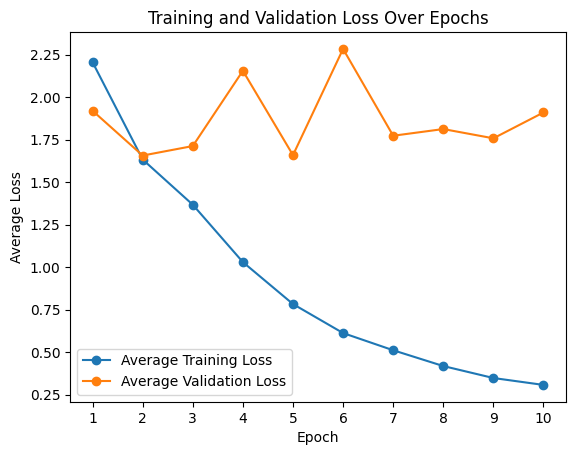

--------------------------------
Test for Full set
--------------------------------


Testing Progress:   0%|          | 0/549 [00:00<?, ?it/s]

Average test loss: 1.9104
RMSE: 1.3822
MSE: 1.9119
MAE: 1.1216
R²: -0.1765
R: 0.2722
True Skill Score: 0.2566
Accuracy: 0.6144
Precision: 0.5207
Recall: 0.4315
F1 Score: 0.4719


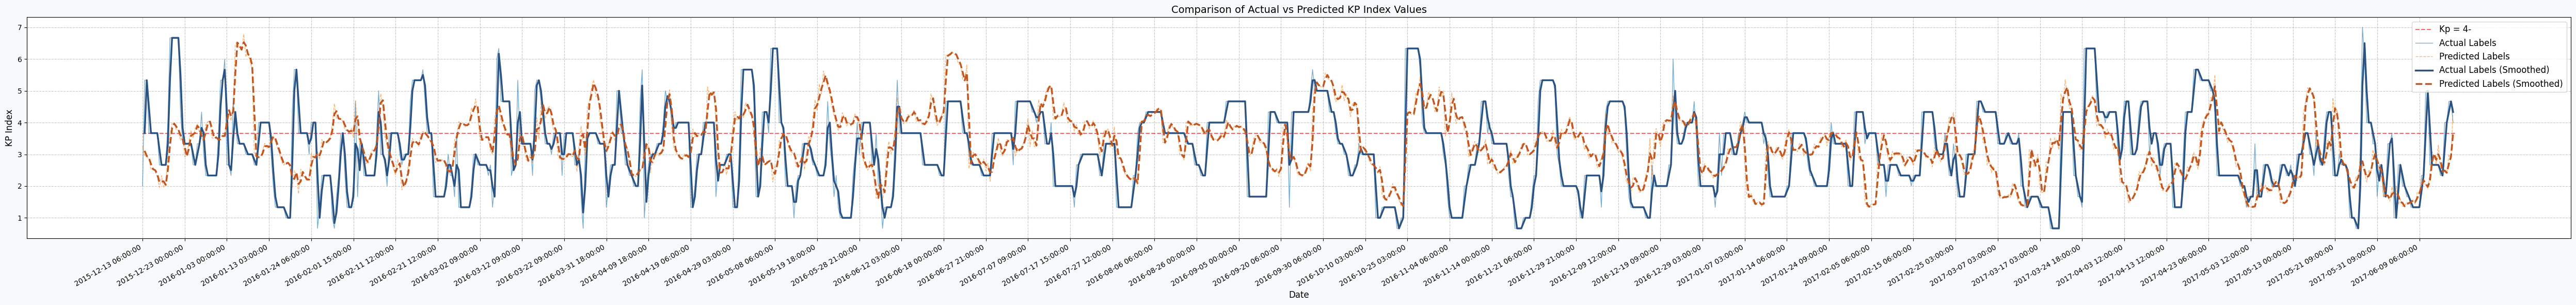

[np.float32(3.25), np.float32(2.96875), np.float32(2.921875), np.float32(2.859375), np.float32(2.53125), np.float32(2.53125), np.float32(2.46875), np.float32(2.28125), np.float32(1.9609375), np.float32(2.328125), np.float32(1.96875), np.float32(2.109375), np.float32(2.90625), np.float32(3.65625), np.float32(3.96875), np.float32(3.96875), np.float32(3.78125), np.float32(3.765625), np.float32(3.4375), np.float32(3.546875), np.float32(2.921875), np.float32(2.953125), np.float32(3.421875), np.float32(3.75), np.float32(3.515625), np.float32(3.84375), np.float32(3.953125), np.float32(3.6875), np.float32(3.46875), np.float32(3.453125), np.float32(3.9375), np.float32(4.03125), np.float32(4.03125), np.float32(3.515625), np.float32(3.5), np.float32(3.5625), np.float32(3.375), np.float32(3.578125), np.float32(3.578125), np.float32(3.578125), np.float32(4.4375), np.float32(4.34375), np.float32(4.0625), np.float32(4.625), np.float32(6.46875), np.float32(6.5625), np.float32(6.3125), np.float32(6.281

Testing Progress:   0%|          | 0/219 [00:00<?, ?it/s]

Average test loss: 1.9689
RMSE: 1.4032
MSE: 1.9689
MAE: 1.1512
R²: -2.4749
R: 0.1993


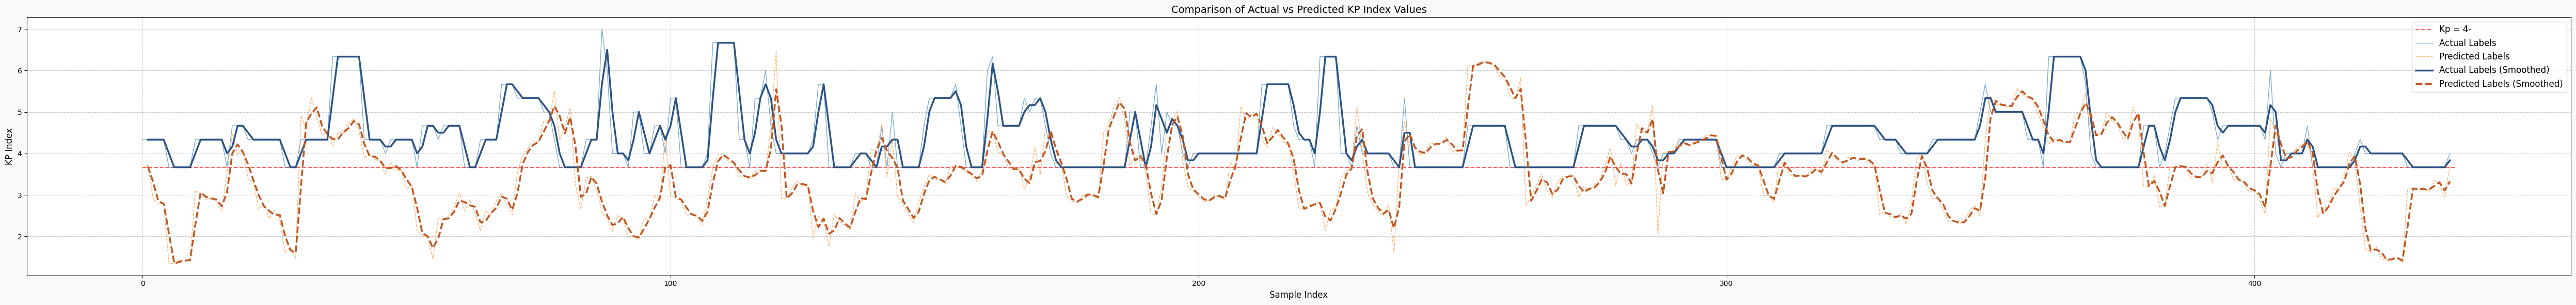

[np.float32(3.65625), np.float32(3.71875), np.float32(2.90625), np.float32(2.78125), np.float32(2.796875), np.float32(1.3515625), np.float32(1.34375), np.float32(1.4296875), np.float32(1.40625), np.float32(1.453125), np.float32(3.109375), np.float32(3.015625), np.float32(2.890625), np.float32(2.9375), np.float32(2.84375), np.float32(2.609375), np.float32(3.53125), np.float32(4.46875), np.float32(3.96875), np.float32(4.09375), np.float32(3.375), np.float32(3.328125), np.float32(2.65625), np.float32(2.796875), np.float32(2.421875), np.float32(2.625), np.float32(2.40625), np.float32(1.609375), np.float32(1.734375), np.float32(1.46875), np.float32(4.90625), np.float32(4.59375), np.float32(5.34375), np.float32(4.875), np.float32(4.4375), np.float32(4.5), np.float32(4.1875), np.float32(4.5), np.float32(4.5), np.float32(4.71875), np.float32(4.84375), np.float32(4.5625), np.float32(3.890625), np.float32(3.984375), np.float32(3.859375), np.float32(3.796875), np.float32(3.5), np.float32(3.796875

Training Progress: Epoch: 1:   0%|          | 0/2194 [00:00<?, ?it/s]

Average Training Loss:  2.215017300506376


Validation Progress: Epoch: 1:   0%|          | 0/550 [00:00<?, ?it/s]

Average Validation Loss:  1.6864632730357434


Training Progress: Epoch: 2:   0%|          | 0/2194 [00:00<?, ?it/s]

Average Training Loss:  1.6507778014930294


Validation Progress: Epoch: 2:   0%|          | 0/550 [00:00<?, ?it/s]

Average Validation Loss:  1.7715347224809441


Training Progress: Epoch: 3:   0%|          | 0/2194 [00:00<?, ?it/s]

Average Training Loss:  1.3802874415424755


Validation Progress: Epoch: 3:   0%|          | 0/550 [00:00<?, ?it/s]

Average Validation Loss:  2.0606568338979163


Training Progress: Epoch: 4:   0%|          | 0/2194 [00:00<?, ?it/s]

Average Training Loss:  1.1202185001972098


Validation Progress: Epoch: 4:   0%|          | 0/550 [00:00<?, ?it/s]

Average Validation Loss:  1.5578334642340301


Training Progress: Epoch: 5:   0%|          | 0/2194 [00:00<?, ?it/s]

Average Training Loss:  0.8472325734171021


Validation Progress: Epoch: 5:   0%|          | 0/550 [00:00<?, ?it/s]

Average Validation Loss:  1.9715525412881238


Training Progress: Epoch: 6:   0%|          | 0/2194 [00:00<?, ?it/s]

Average Training Loss:  0.6817107620576771


Validation Progress: Epoch: 6:   0%|          | 0/550 [00:00<?, ?it/s]

Average Validation Loss:  1.6519026150387204


Training Progress: Epoch: 7:   0%|          | 0/2194 [00:00<?, ?it/s]

Average Training Loss:  0.5636482462534875


Validation Progress: Epoch: 7:   0%|          | 0/550 [00:00<?, ?it/s]

Average Validation Loss:  1.6986246032269925


Training Progress: Epoch: 8:   0%|          | 0/2194 [00:00<?, ?it/s]

Average Training Loss:  0.47886834366076947


Validation Progress: Epoch: 8:   0%|          | 0/550 [00:00<?, ?it/s]

Average Validation Loss:  1.608301239829214


Training Progress: Epoch: 9:   0%|          | 0/2194 [00:00<?, ?it/s]

Average Training Loss:  0.3905495371944243


Validation Progress: Epoch: 9:   0%|          | 0/550 [00:00<?, ?it/s]

Average Validation Loss:  1.5569896927189124


Training Progress: Epoch: 10:   0%|          | 0/2194 [00:00<?, ?it/s]

Average Training Loss:  0.35156975830268045


Validation Progress: Epoch: 10:   0%|          | 0/550 [00:00<?, ?it/s]

Average Validation Loss:  1.6138880407879135


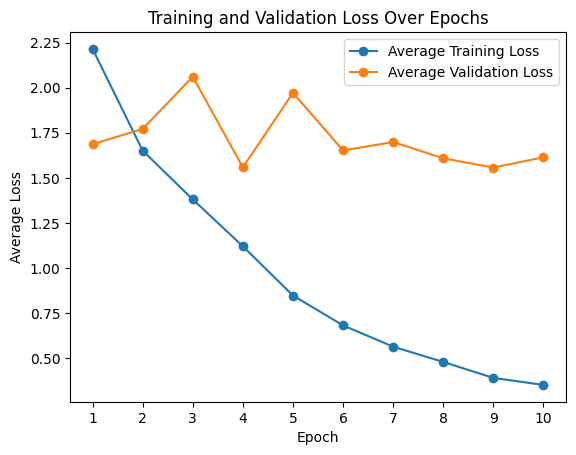

--------------------------------
Test for Full set
--------------------------------


Testing Progress:   0%|          | 0/550 [00:00<?, ?it/s]

Average test loss: 1.6139
RMSE: 1.2704
MSE: 1.6149
MAE: 1.0386
R²: 0.0405
R: 0.3552
True Skill Score: 0.2674
Accuracy: 0.7106
Precision: 0.4032
Recall: 0.2660
F1 Score: 0.3205


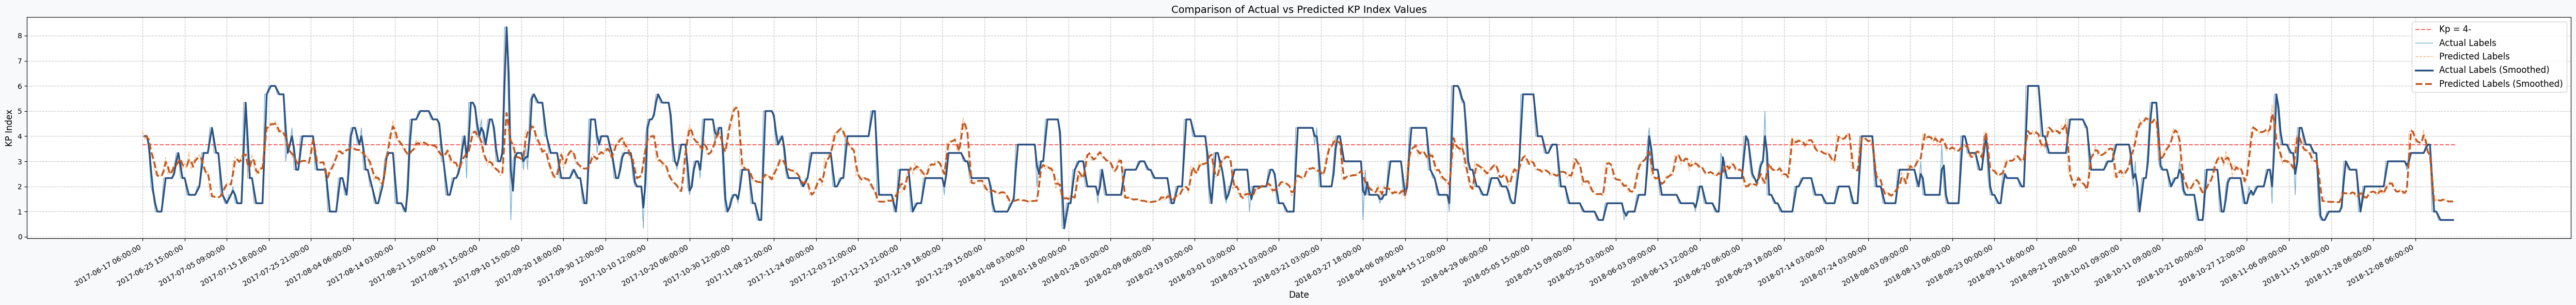

[np.float32(4.1875), np.float32(3.875), np.float32(4.0625), np.float32(3.671875), np.float32(3.15625), np.float32(3.125), np.float32(2.46875), np.float32(2.40625), np.float32(2.421875), np.float32(2.40625), np.float32(2.796875), np.float32(3.140625), np.float32(2.484375), np.float32(2.5), np.float32(2.6875), np.float32(2.921875), np.float32(2.765625), np.float32(3.1875), np.float32(3.015625), np.float32(2.6875), np.float32(2.921875), np.float32(2.71875), np.float32(3.375), np.float32(2.6875), np.float32(2.875), np.float32(3.171875), np.float32(3.0625), np.float32(3.28125), np.float32(2.9375), np.float32(2.671875), np.float32(2.484375), np.float32(2.609375), np.float32(1.6015625), np.float32(1.625), np.float32(1.5625), np.float32(1.5703125), np.float32(1.5703125), np.float32(1.640625), np.float32(1.8359375), np.float32(2.03125), np.float32(2.125), np.float32(2.109375), np.float32(2.046875), np.float32(2.96875), np.float32(3.171875), np.float32(2.984375), np.float32(2.96875), np.float32(

Testing Progress:   0%|          | 0/141 [00:00<?, ?it/s]

Average test loss: 2.5032
RMSE: 1.5821
MSE: 2.5032
MAE: 1.3576
R²: -3.2347
R: 0.4070


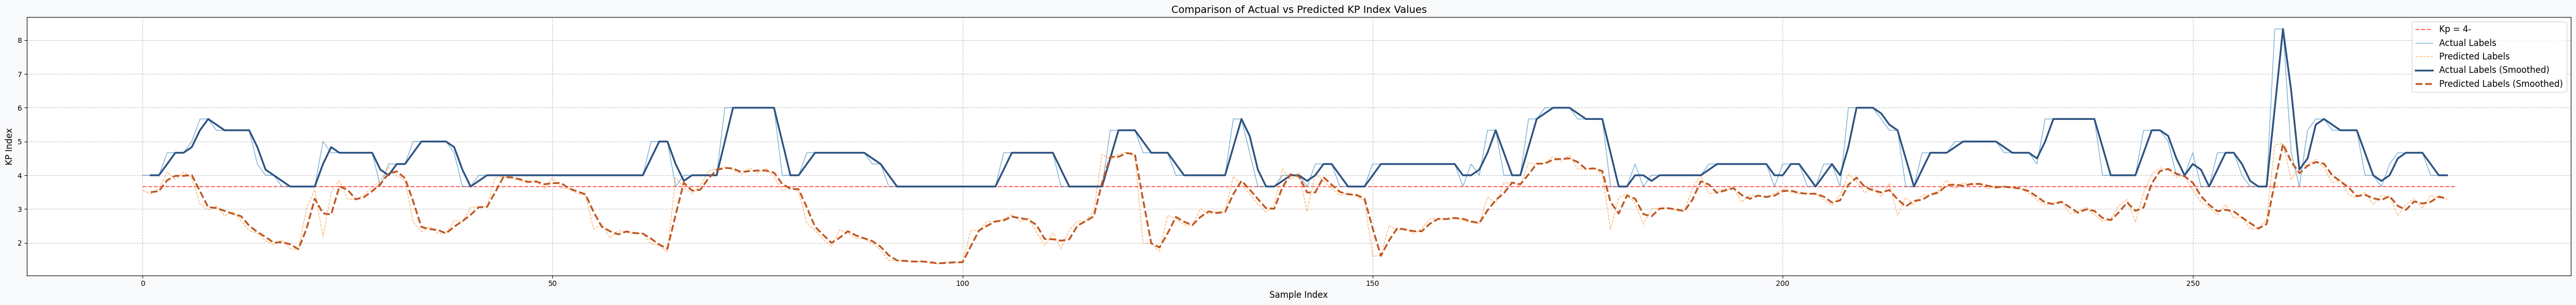

[np.float32(3.546875), np.float32(3.453125), np.float32(3.609375), np.float32(4.09375), np.float32(3.875), np.float32(4.09375), np.float32(3.921875), np.float32(3.140625), np.float32(2.96875), np.float32(3.09375), np.float32(2.796875), np.float32(2.921875), np.float32(2.65625), np.float32(2.359375), np.float32(2.28125), np.float32(2.0625), np.float32(1.9453125), np.float32(2.09375), np.float32(1.8203125), np.float32(1.8046875), np.float32(3.03125), np.float32(3.578125), np.float32(2.171875), np.float32(3.5), np.float32(3.84375), np.float32(3.296875), np.float32(3.28125), np.float32(3.421875), np.float32(3.640625), np.float32(3.84375), np.float32(4.25), np.float32(3.984375), np.float32(3.84375), np.float32(2.609375), np.float32(2.328125), np.float32(2.484375), np.float32(2.28125), np.float32(2.28125), np.float32(2.671875), np.float32(2.609375), np.float32(3.046875), np.float32(3.0625), np.float32(3.0625), np.float32(3.9375), np.float32(3.953125), np.float32(3.921875), np.float32(3.84375

In [ ]:
torch.set_float32_matmul_precision('medium')
fabric = Fabric(accelerator='cuda', devices=1, precision="bf16-mixed")
fabric.launch(train_model)

In [ ]:
# prompt: disconnect runtime
import time
time.sleep(5 * 60)
from google.colab import runtime
runtime.unassign()
